In [12]:
import sys
sys.path.insert(0, "../../")

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from mlxtend.plotting import plot_decision_regions

from data import parse_dataset
from base import load_hyperparameters
from experiments.experiment import AbstractSklearnExperiment
from experiments.statistical import get_ner_wrapper, get_sentiment_wrapper
import statistical.data_extraction as ex

In [15]:
x, y = parse_dataset("../../datasets", "en")
kfold = StratifiedKFold(n_splits=10)
splits = list(kfold.split(x, y))


def load_model(path_to_hyperparameters, model_type):
    hp = load_hyperparameters(path_to_hyperparameters)
    model = AbstractSklearnExperiment.build_model(AbstractSklearnExperiment, hp)

    if model_type == "readability":
        extractor = ex.readability_tweet_extractor()
    elif model_type == "ner":
        extractor = ex.ner_tweet_extractor(get_ner_wrapper(hp))
    elif model_type == "sentiment":
        extractor = ex.sentiment_tweet_extractor(get_sentiment_wrapper(hp))
    else:
        raise ValueError("Invalid value for `model_type`")

    return extractor, model


def fit_model(path_to_hyperparameters, model_type):
    extractor, model = load_model(path_to_hyperparameters, model_type)
    xt = extractor.transform(x)

    predictions = []
    for x_train_indices, x_test_indices in splits:
        x_train = xt[x_train_indices]
        y_train = y[x_train_indices]
        x_test = xt[x_test_indices]
        y_test = y[x_test_indices]

        model.fit(x_train, y_train)
        pred = model.predict_proba(x_test)
        predictions.append([pred, y_test])

    return np.asarray(predictions)

In [186]:
def plot_roc(predictions):
    rates = np.asarray([roc_curve(y_true, pred[:, -1].reshape(-1))[:2] for pred, y_true in predictions])
    length = max([len(fpr) for fpr, _ in rates])
    rates = np.asarray([
        [np.pad(fpr, (0, length-len(fpr)), constant_values=1.), np.pad(tpr, (0, length-len(tpr)), constant_values=1.)]
        for fpr, tpr in rates
    ])
    rates_mean = np.mean(rates, axis=0)
    rates_mean_plus_std = rates_mean[1] + np.std(rates[1], axis=0)
    rates_mean_minus_std = rates_mean[1] - np.std(rates[1], axis=0)

    print("AUC:", auc(rates_mean[0], rates_mean[1]))
    plt.plot(rates_mean[0], rates_mean[1])
    plt.plot(rates_mean[0], rates_mean_plus_std, color="blue", alpha=0.2)
    plt.plot(rates_mean[0], rates_mean_minus_std, color="blue", alpha=0.2)
    plt.fill_between(rates_mean[0], rates_mean_minus_std, rates_mean_plus_std, alpha=0.2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")


def plot_model_decision_regions(path_to_hyperparameters, model_type):
    extractor, model = load_model(path_to_hyperparameters, model_type)
    xt = extractor.transform(x)

    model.fit(xt, y)
    plot_decision_regions(xt, y.astype(np.int32), clf=model, legend=2)
    plt.title("Decision Regions")

def plot_confusion_matrix(predictions):
    matrices = []
    for pred, y_trues in predictions:
        confusion_matrix = np.full((2, 2), 0)
        y_preds = np.argmax(pred, axis=1)

        for y_pred, y_true in zip(y_preds, y_trues):
            if y_pred == 1 and y_true == 1:  # True positive
                confusion_matrix[0, 0] += 1
            elif y_pred == 1 and y_true == 0:  # False positive
                confusion_matrix[0, 1] += 1
            elif y_pred == 0 and y_true == 0:  # True negative
                confusion_matrix[1, 1] += 1
            elif y_pred == 0 and y_true == 1:  # False negative
                confusion_matrix[1, 0] += 1

        matrices.append(confusion_matrix)

    confusion_matrix = np.mean(matrices, axis=0)
    sn.heatmap(confusion_matrix, annot=True, xticklabels=[1, 0], yticklabels=[1, 0])

# Readability model

In [124]:
predictions = fit_model(
    "../../training/statistical/readability_10/trial_0be075eee1b0230e51a4517cc721c747/trial.json", "readability")

c:\users\joshh\desktop\uni\soton uni - yr 3\comp3200\fake-news-profiling\venv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\joshh\desktop\uni\soton uni - yr 3\comp3200\fake-news-profiling\venv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, U

[23:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

AUC: 0.697221194937541


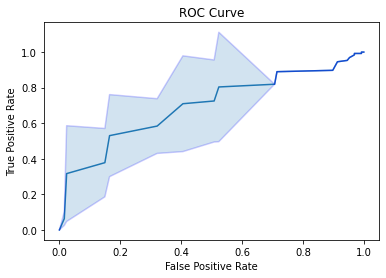

In [152]:
plot_roc(predictions)

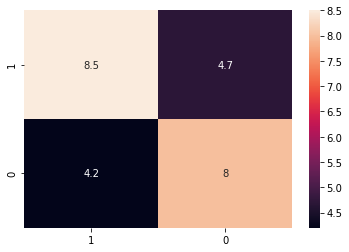

In [187]:
plot_confusion_matrix(predictions)